In [1]:
from datetime import datetime
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams

from statsmodels.tsa.stattools import adfuller
!pip install pmdarima --quiet
import pmdarima as pm

## Load data

In [3]:
df = pd.read_csv('Data/AirPassengers.csv')

df['Month'] = pd.to_datetime(df['Month'])
df = df.set_index(['Month'])
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


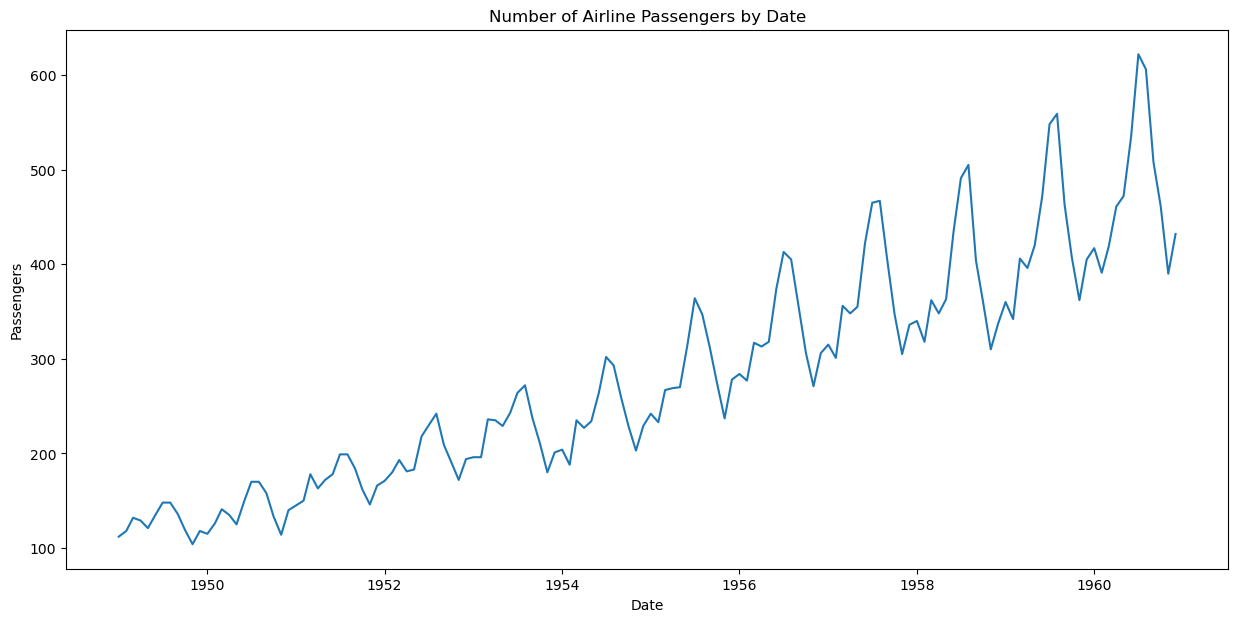

In [5]:
plt.figure(figsize=(15,7))
plt.title("Number of Airline Passengers by Date")
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.plot(df)
plt.show()

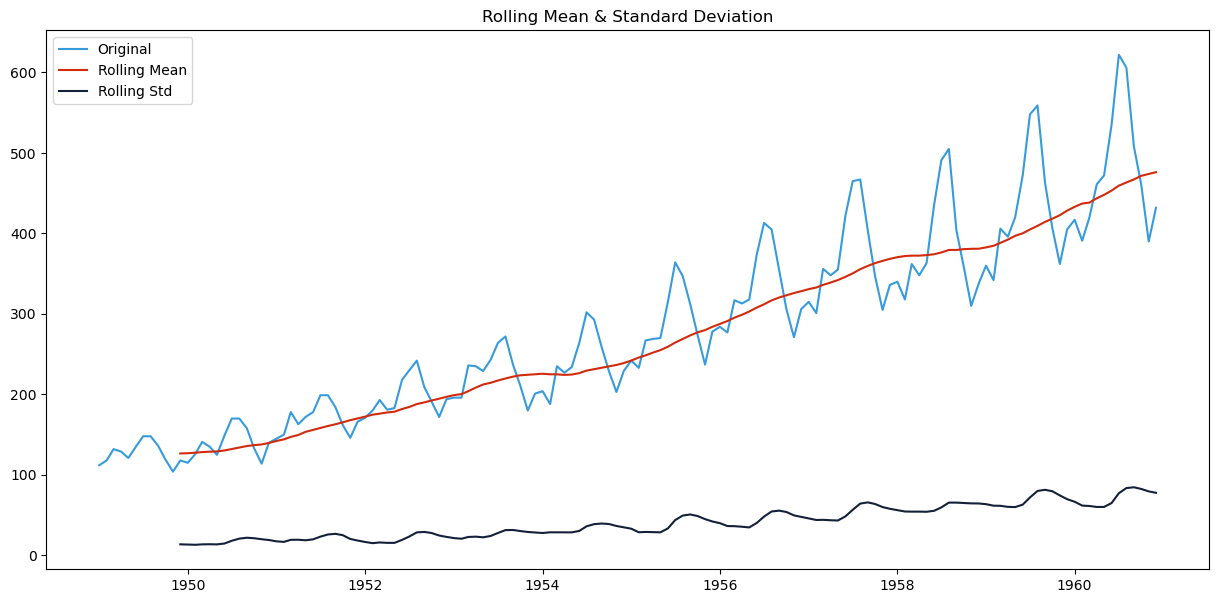

In [6]:
#Determine rolling statistics
df["rolling_avg"] = df["#Passengers"].rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
df["rolling_std"] = df["#Passengers"].rolling(window=12).std()

#Plot rolling statistics
plt.figure(figsize=(15,7))
plt.plot(df["#Passengers"], color='#379BDB', label='Original')
plt.plot(df["rolling_avg"], color='#D22A0D', label='Rolling Mean')
plt.plot(df["rolling_std"], color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [7]:
#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(df['#Passengers'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [8]:
#Standard ARIMA Model
ARIMA_model = pm.auto_arima(df['#Passengers'],
                            start_p=1,
                            start_q=1,
                            test='adf', # use adftest to find optimal 'd'
                            max_p=3, max_q=3, # maximum p and q
                            m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                            d=None,# let model determine 'd'
                            seasonal=False, # No Seasonality for standard ARIMA
                            trace=False, #logs 
                            error_action='warn', #shows errors ('ignore' silences these)
                            suppress_warnings=True,
                            stepwise=True)

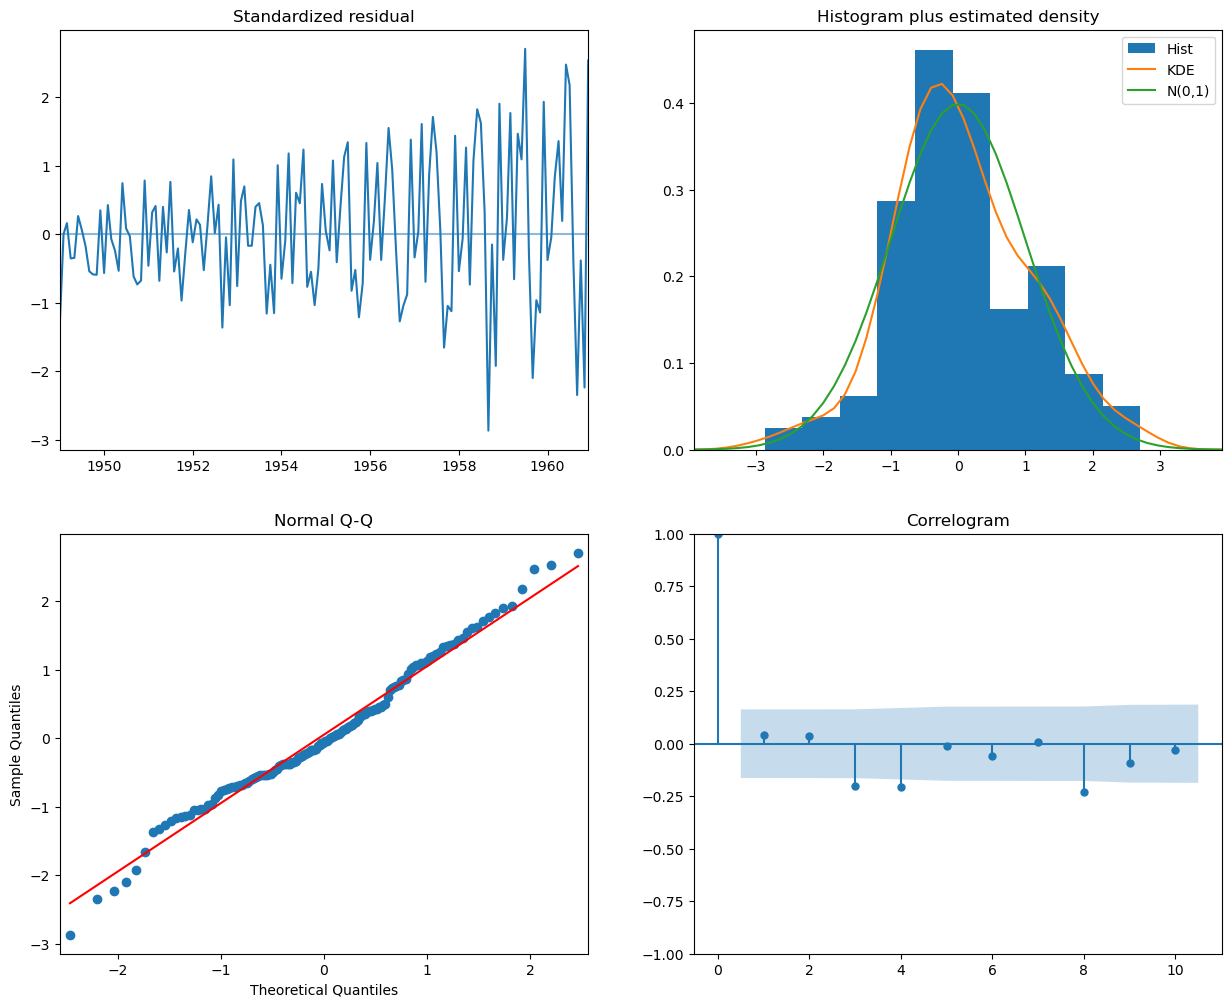

In [9]:
ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

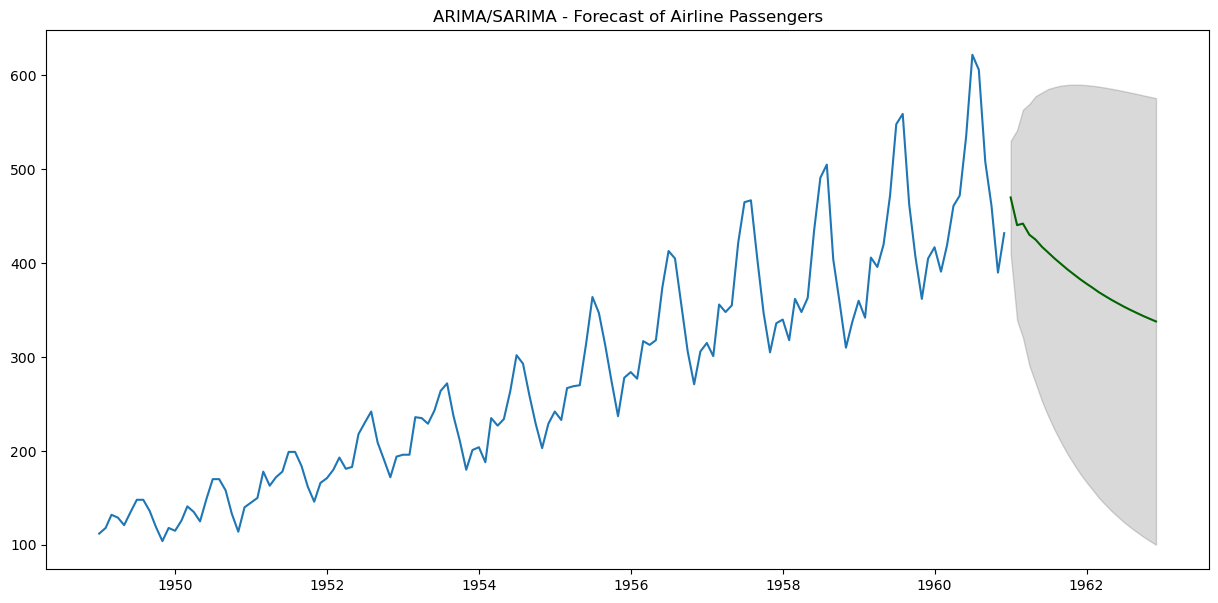

In [10]:
def forecast(ARIMA_model, periods=24):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df["#Passengers"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index,
                     lower_series,
                     upper_series,
                     color='k', alpha=.15)

    plt.title("ARIMA/SARIMA - Forecast of Airline Passengers")
    plt.show()

forecast(ARIMA_model)

In [11]:
# Seasonal - fit stepwise auto-ARIMA
SARIMA_model = pm.auto_arima(df["#Passengers"], start_p=1, start_q=1,
                             test='adf',
                             max_p=3, max_q=3,
                             m=12, #12 is the frequncy of the cycle
                             start_P=0,
                             seasonal=True, #set to seasonal
                             d=None,
                             D=1, #order of the seasonal differencing
                             trace=False,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True)

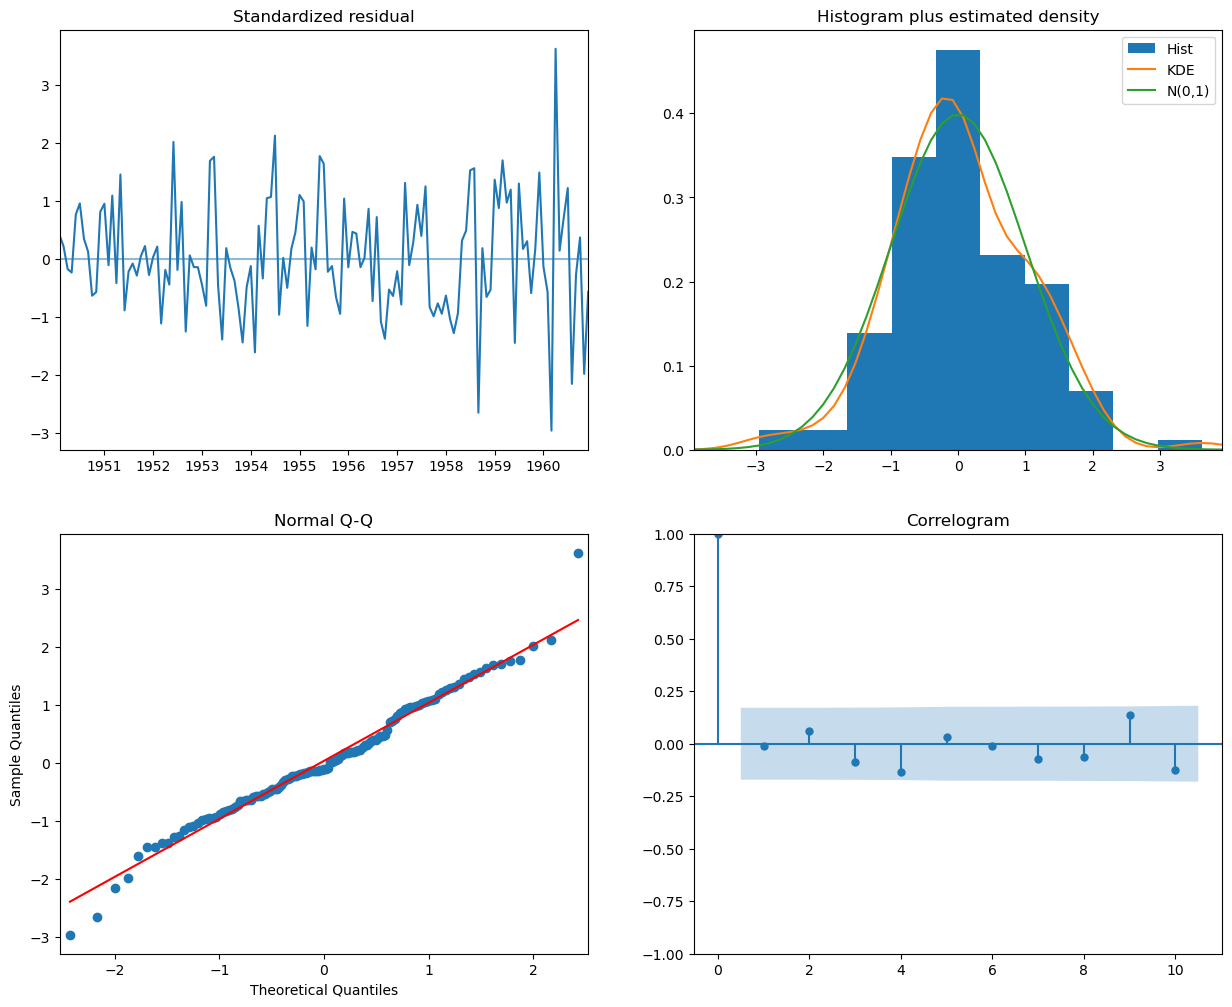

In [12]:
SARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

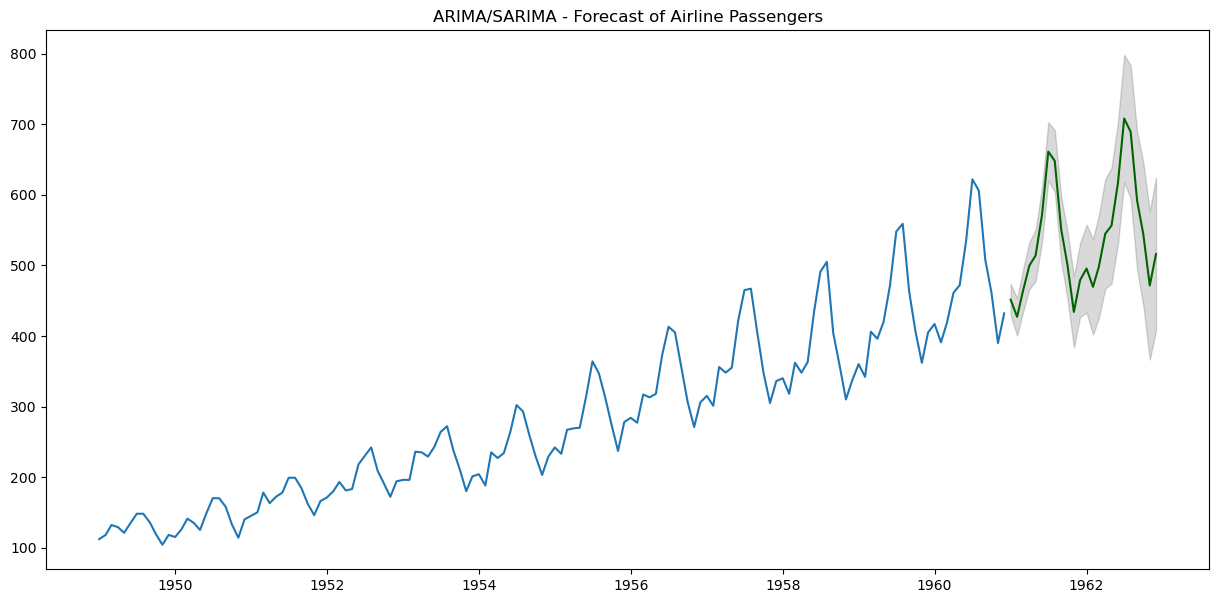

In [13]:
forecast(SARIMA_model)

In [14]:
#adding exogenous variable
df['month_index'] = df.index.month

# SARIMAX Model
SARIMAX_model = pm.auto_arima(df[['#Passengers']], exogenous=df[['month_index']],
                              start_p=1, start_q=1,
                              test='adf',
                              max_p=3, max_q=3, m=12,
                              start_P=0, seasonal=True,
                              d=None, D=1,
                              trace=False,
                              error_action='ignore',
                              suppress_warnings=True,
                              stepwise=True)

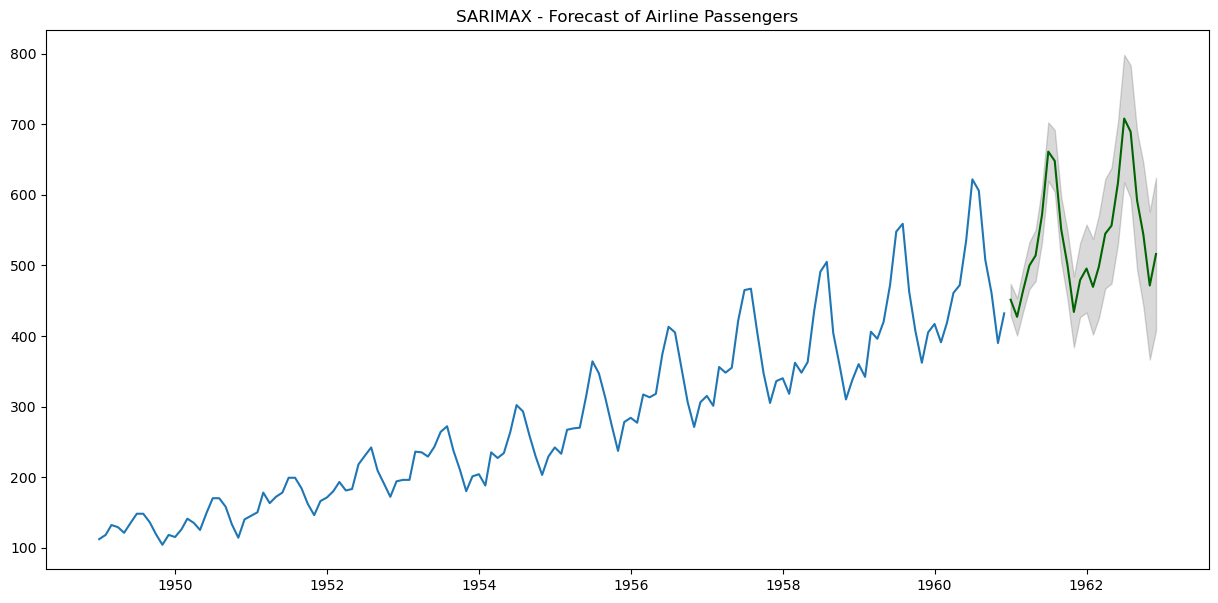

In [15]:
def sarimax_forecast(SARIMAX_model, periods=24):
    # Forecast
    n_periods = periods

    forecast_df = pd.DataFrame({"month_index":pd.date_range(df.index[-1], periods = n_periods, freq='MS').month},
                               index = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS'))

    fitted, confint = SARIMAX_model.predict(n_periods=n_periods,
                                            return_conf_int=True,
                                            exogenous=forecast_df[['month_index']])
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df["#Passengers"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index,
                     lower_series,
                     upper_series,
                     color='k', alpha=.15)

    plt.title("SARIMAX - Forecast of Airline Passengers")
    plt.show()

sarimax_forecast(SARIMAX_model, periods=24)